In [192]:
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import chromedriver_binary

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from math import sqrt

### Scraping

In [193]:
#This scrapes the google trends website for the csv I need to run trends data. Turns out the table I wanted from the CMS website wouldn't populate.
# url = 'https://portal.cms.gov/wps/portal/unauthportal/unauthmicrostrategyreportslink?evt=2048001&src=mstrWeb.2048001&documentID=203D830811E7EBD800000080EF356F31&visMode=0&currentViewMedia=1&Server=E48V126P&Project=OIPDA-BI_Prod&Port=0&connmode=8&ru=1&share=1&hiddensections=header,path,dockTop,dockLeft,footer'
url = 'https://trends.google.com/trends/?geo=US'
response  = requests.get(url)
# print(response.text)

driver = webdriver.Chrome()
driver.get(url)
driver.maximize_window()
time.sleep(1)


username_form = driver.find_element_by_id("input-1")
username_form.send_keys('insulin pricing')
username_form.send_keys(Keys.RETURN)
click_label = driver.find_element_by_id('select_value_label_10') #Once it changed from *label_11. Watch out for this
click_label.click()
click2 = driver.find_element_by_id('select_option_22').click() #This changed from 23 as well.
download = driver.find_element_by_xpath("//button[@class='widget-actions-item export']")
download.click() #Yay!

### Functions

In [59]:
#defines root mean square error
def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [18]:
#takes a list, checks a column for its contents, returns a boolean which can be used as a mask
def _check_column_for_list(x):
    return any([y in x for y in list(insulin_mask['brandname'])]) 

In [147]:
#applies an elastic net with inputtable random state
def iterate_elastic_net(df,ranstate):
    X = df.loc[:,['Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]
    y = df['Total Spending']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=ranstate)
    
    lm_elastic_test = ElasticNet(alpha = best_alpha, l1_ratio=.5)
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lm_elastic_test.fit(X_scaled, y_train)
    
    

    val_set_pred = lm_elastic_test.predict(X_test_scaled)
    err_vec_val[i] = rmse(y_test, val_set_pred)
    
    return list(zip(selected_columns, lm_elastic_test.coef_))
    

### Cleaning

In [2]:
data_xls = pd.read_excel('Medicare Part D Drug Spending YTD 2017.xlsx', 'Manufacturer Summary', index_col=None)
drug_info = pd.read_excel('Medicare Part D Drug Spending YTD 2017.xlsx', 'Drug Use Information', index_col=None)
drug_info = pd.read_excel('Medicare Part D Drug Spending YTD 2017.xlsx', 'Drug Use Information', index_col=None)

In [3]:
headers = data_xls.iloc[4]
new_df = pd.DataFrame(data_xls.values[1:], columns=headers)

In [4]:
#rename columns, drop unneeded ones & nulls, and provide sample of first 5 rows
drug_info.rename(columns={'Medicare Part D Drug Use Information, Calendar Year 2017':'brandname', 'Unnamed: 1':'genericname', 'Unnamed: 2':'description'},inplace=True)
drug_info_cleaned = drug_info.drop([0,1,2,3])
drug_info_cleaned = drug_info_cleaned.dropna()
drug_info_cleaned.head(5)


,brandname,genericname,description
4,1st Tier Unifine Pentips,"Pen Needle, Diabetic",Drug uses not available
5,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",Drug uses not available
6,Abacavir,Abacavir Sulfate,This drug is used with other HIV medications t...
7,Abacavir-Lamivudine,Abacavir Sulfate/Lamivudine,This product contains 2 drugs: abacavir and la...
8,Abacavir-Lamivudine-Zidovudine,Abacavir/Lamivudine/Zidovudine,"This product contains 3 drugs: abacavir, lamiv..."


In [5]:
#create filter for insulin only. All drugs below were researched and confirmed to be insulin, and made by one of the three primary manufacturers (Novo Nordisk, Eli Lilly, and Sanofi) with the exception of Afrezza, which is its own company, MannKind (fun fact: it's inhalable) 
insulin_info = drug_info_cleaned[drug_info_cleaned['description'].str.contains('is used with a proper diet and exercise program to control high blood sugar in people with diabetes')] #found a pattern in the descriptions! 
insulin_mask = insulin_info[~insulin_info['genericname'].str.contains('Syringe')]
insulin_mask.sort_values(['genericname'])
insulin_mask

,brandname,genericname,description
65,Afrezza,"Insulin Regular, Human",Inhaled insulin powder is used with a proper d...
164,Apidra,Insulin Glulisine,Insulin glulisine is used with a proper diet a...
165,Apidra Solostar,Insulin Glulisine,Insulin glulisine is used with a proper diet a...
266,Basaglar Kwikpen U-100,"Insulin Glargine,Hum.Rec.Anlog",Insulin glargine is used with a proper diet an...
1161,Humalog,Insulin Lispro,Insulin lispro is used with a proper diet and ...
1162,Humalog Kwikpen U-100,Insulin Lispro,Insulin lispro is used with a proper diet and ...
1163,Humalog Kwikpen U-200,Insulin Lispro,Insulin lispro is used with a proper diet and ...
1174,Humulin 70-30,Insulin NPh Hum/Reg Insulin Hm,Combination isophane/regular insulin is used w...
1175,Humulin 70/30 Kwikpen,Insulin NPh Hum/Reg Insulin Hm,Combination isophane/regular insulin is used w...
1176,Humulin N,Insulin NPh Human Isophane,Insulin isophane is used with a proper diet an...


In [6]:
#make new df for each years' data from excel's incompatible format.
df_manus = new_df.iloc[:,0:3]
df_2013 = new_df.iloc[:,3:10]
df_2014 = new_df.iloc[:,10:17]
df_2015 = new_df.iloc[:,17:24]
df_2016 = new_df.iloc[:,24:31]
df_2017 = new_df.iloc[:,31:38]

In [7]:
#create structure for the unique identifier.
df_manus['ID'] = df_manus['Brand Name'] + '/' + df_manus['Generic Name'] + '/' + df_manus['Manufacturer']

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
#create ID columns in each df, and add year column.
df_list = [df_2013, df_2014, df_2015, df_2016, df_2017]
year = 2013
for df in df_list:
    df['ID'] = df_manus['ID']
    df['Year'] = str(year)
    year += 1

    

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
#combine dfs
cdf = pd.concat([df_2013,df_2014,df_2015,df_2016,df_2017]).reset_index(drop=True)

In [10]:
grpcdf = cdf.sort_values(['ID', 'Year'])
grpcdf.columns = grpcdf.columns.str.strip()
grpcdf.rename(columns={'Total \nClaims':'Total Claims'},inplace=True)
grpcdf.columns

Index(['Total Spending', 'Total Dosage Units', 'Total Claims',
       'Total Beneficiaries', 'Average Spending Per Dosage Unit (Weighted)',
       'Average Spending Per Claim', 'Average Spending Per Beneficiary', 'ID',
       'Year'],
      dtype='object', name=4)

In [11]:
cols = ['ID', 'Year', 'Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries', 'Average Spending Per Dosage Unit (Weighted)', 'Average Spending Per Claim', 'Average Spending Per Beneficiary']
grpcdf = grpcdf[cols]


In [12]:
drop_null = grpcdf.dropna()

In [13]:
intcols = ['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries', 'Average Spending Per Dosage Unit (Weighted)', 'Average Spending Per Claim', 'Average Spending Per Beneficiary']
drop_null[intcols] = drop_null[intcols].apply(pd.to_numeric, errors='coerce', axis=1) #errors 'coerce' turns the values to NaN that don't work.
drop_null['dt_year'] = pd.to_datetime(drop_null['Year'])

/home/nick/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
with open('clean_df.pickle', 'wb') as to_write:
    pickle.dump(drop_null, to_write)
    

### Create insulin dataframes

In [16]:
with open('clean_df.pickle', 'rb') as read_file:
    cleaned_df = pickle.load(read_file)

In [17]:
cleaned_df2 = cleaned_df.copy()

In [19]:
boolean_split = cleaned_df2.ID.map(_check_column_for_list) #this searches the df for all insulin drug names and creates an insuling df by using the mask from the boolean.
boolean_split.value_counts()
insulin_df = cleaned_df2[boolean_split]

In [20]:
insulin_df.sample(10)

4,ID,Year,Total Spending,Total Dosage Units,Total Claims,Total Beneficiaries,Average Spending Per Dosage Unit (Weighted),Average Spending Per Claim,Average Spending Per Beneficiary,dt_year
3019,Humulin 70/30 Kwikpen/Insulin NPh Hum/Reg Insu...,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01
6553,"Toujeo Solostar/Insulin Glargine,Hum.Rec.Anlog...",2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01
25218,"Lantus Solostar/Insulin Glargine,Hum.Rec.Anlog...",2016,2.526426e+09,1.026912e+08,5029203.0,1075461.0,24.602169,502.351263,2349.156760,2016-01-01
4797,Novolog Flexpen/Insulin Aspart/Novo Nordisk,2013,6.196661e+08,3.231045e+07,1579973.0,425402.0,19.178505,392.200421,1456.659998,2013-01-01
31903,"Humulin R U-500/Insulin Regular, Human/Eli Lil...",2017,1.456746e+08,2.062050e+06,73194.0,14547.0,70.645531,1990.253524,10014.065887,2017-01-01
24667,Humalog Kwikpen U-200/Insulin Lispro/Eli Lilly...,2016,5.707476e+07,9.111670e+05,55104.0,17573.0,62.639185,1035.764339,3247.866507,2016-01-01
3010,Humalog Mix 75-25/Insulin Lispro Protamin/Lisp...,2013,9.411063e+07,6.309951e+06,238482.0,44300.0,14.914638,394.623622,2124.393470,2013-01-01
26456,Novolog/Insulin Aspart/Novo Nordisk,2016,5.797479e+08,2.317699e+07,1230313.0,283933.0,25.008167,471.219871,2041.847667,2016-01-01
29016,"Afrezza/Insulin Regular, Human/Mannkind Corpor",2017,1.538984e+06,4.242780e+05,2231.0,639.0,3.543422,689.818243,2408.426448,2017-01-01
31904,"Humulin R U-500 Kwikpen/Insulin Regular, Human...",2017,1.017165e+08,1.116094e+06,66332.0,13153.0,91.136103,1533.444983,7733.328719,2017-01-01


In [21]:
with open('clean_insulin_df.pickle', 'wb') as to_write:
    pickle.dump(insulin_df, to_write)

### Create yearly insulin dfs

In [22]:
with open('clean_insulin_df.pickle', 'rb') as read_file:
    insulin_df = pickle.load(read_file)

In [24]:
insulin_df.sort_values('Average Spending Per Dosage Unit (Weighted)', ascending=False)

4,ID,Year,Total Spending,Total Dosage Units,Total Claims,Total Beneficiaries,Average Spending Per Dosage Unit (Weighted),Average Spending Per Claim,Average Spending Per Beneficiary,dt_year
31904,"Humulin R U-500 Kwikpen/Insulin Regular, Human...",2017,1.017165e+08,1.116094e+06,66332.0,13153.0,91.136103,1533.444983,7733.328719,2017-01-01
24684,"Humulin R U-500 Kwikpen/Insulin Regular, Human...",2016,2.837161e+07,3.265010e+05,19413.0,NaN,86.895931,1461.474695,NaN,2016-01-01
35433,"Toujeo Solostar/Insulin Glargine,Hum.Rec.Anlog...",2017,5.419546e+08,7.209778e+06,934611.0,190489.0,75.169392,579.871886,2845.070547,2017-01-01
20993,"Toujeo Solostar/Insulin Glargine,Hum.Rec.Anlog...",2015,5.689673e+07,7.667696e+05,99137.0,43006.0,74.203173,573.920268,1322.995247,2015-01-01
28213,"Toujeo Solostar/Insulin Glargine,Hum.Rec.Anlog...",2016,3.453243e+08,4.670429e+06,621495.0,148357.0,73.938468,555.634935,2327.657839,2016-01-01
31903,"Humulin R U-500/Insulin Regular, Human/Eli Lil...",2017,1.456746e+08,2.062050e+06,73194.0,14547.0,70.645531,1990.253524,10014.065887,2017-01-01
31887,Humalog Kwikpen U-200/Insulin Lispro/Eli Lilly...,2017,9.422941e+07,1.386292e+06,83091.0,23598.0,67.972265,1134.050702,3993.109878,2017-01-01
24683,"Humulin R U-500/Insulin Regular, Human/Eli Lil...",2016,1.674151e+08,2.617328e+06,91109.0,18442.0,63.964114,1837.525025,9077.923626,2016-01-01
24667,Humalog Kwikpen U-200/Insulin Lispro/Eli Lilly...,2016,5.707476e+07,9.111670e+05,55104.0,17573.0,62.639185,1035.764339,3247.866507,2016-01-01
35494,Tresiba Flextouch U-200/Insulin Degludec/Novo ...,2017,3.272190e+08,5.525023e+06,371889.0,89703.0,59.224918,879.883602,3647.804788,2017-01-01


In [25]:
year_mask_2013 = insulin_df['Year'] == '2013'
insulin_2013 = insulin_df[year_mask_2013]

year_mask_2014 = insulin_df['Year'] == '2014'
insulin_2014 = insulin_df[year_mask_2014]

year_mask_2015 = insulin_df['Year'] == '2015'
insulin_2015 = insulin_df[year_mask_2015]

year_mask_2016 = insulin_df['Year'] == '2016'
insulin_2016 = insulin_df[year_mask_2016]

year_mask_2017 = insulin_df['Year'] == '2017'
insulin_2017 = insulin_df[year_mask_2017]

### Create Heatmaps for correlations

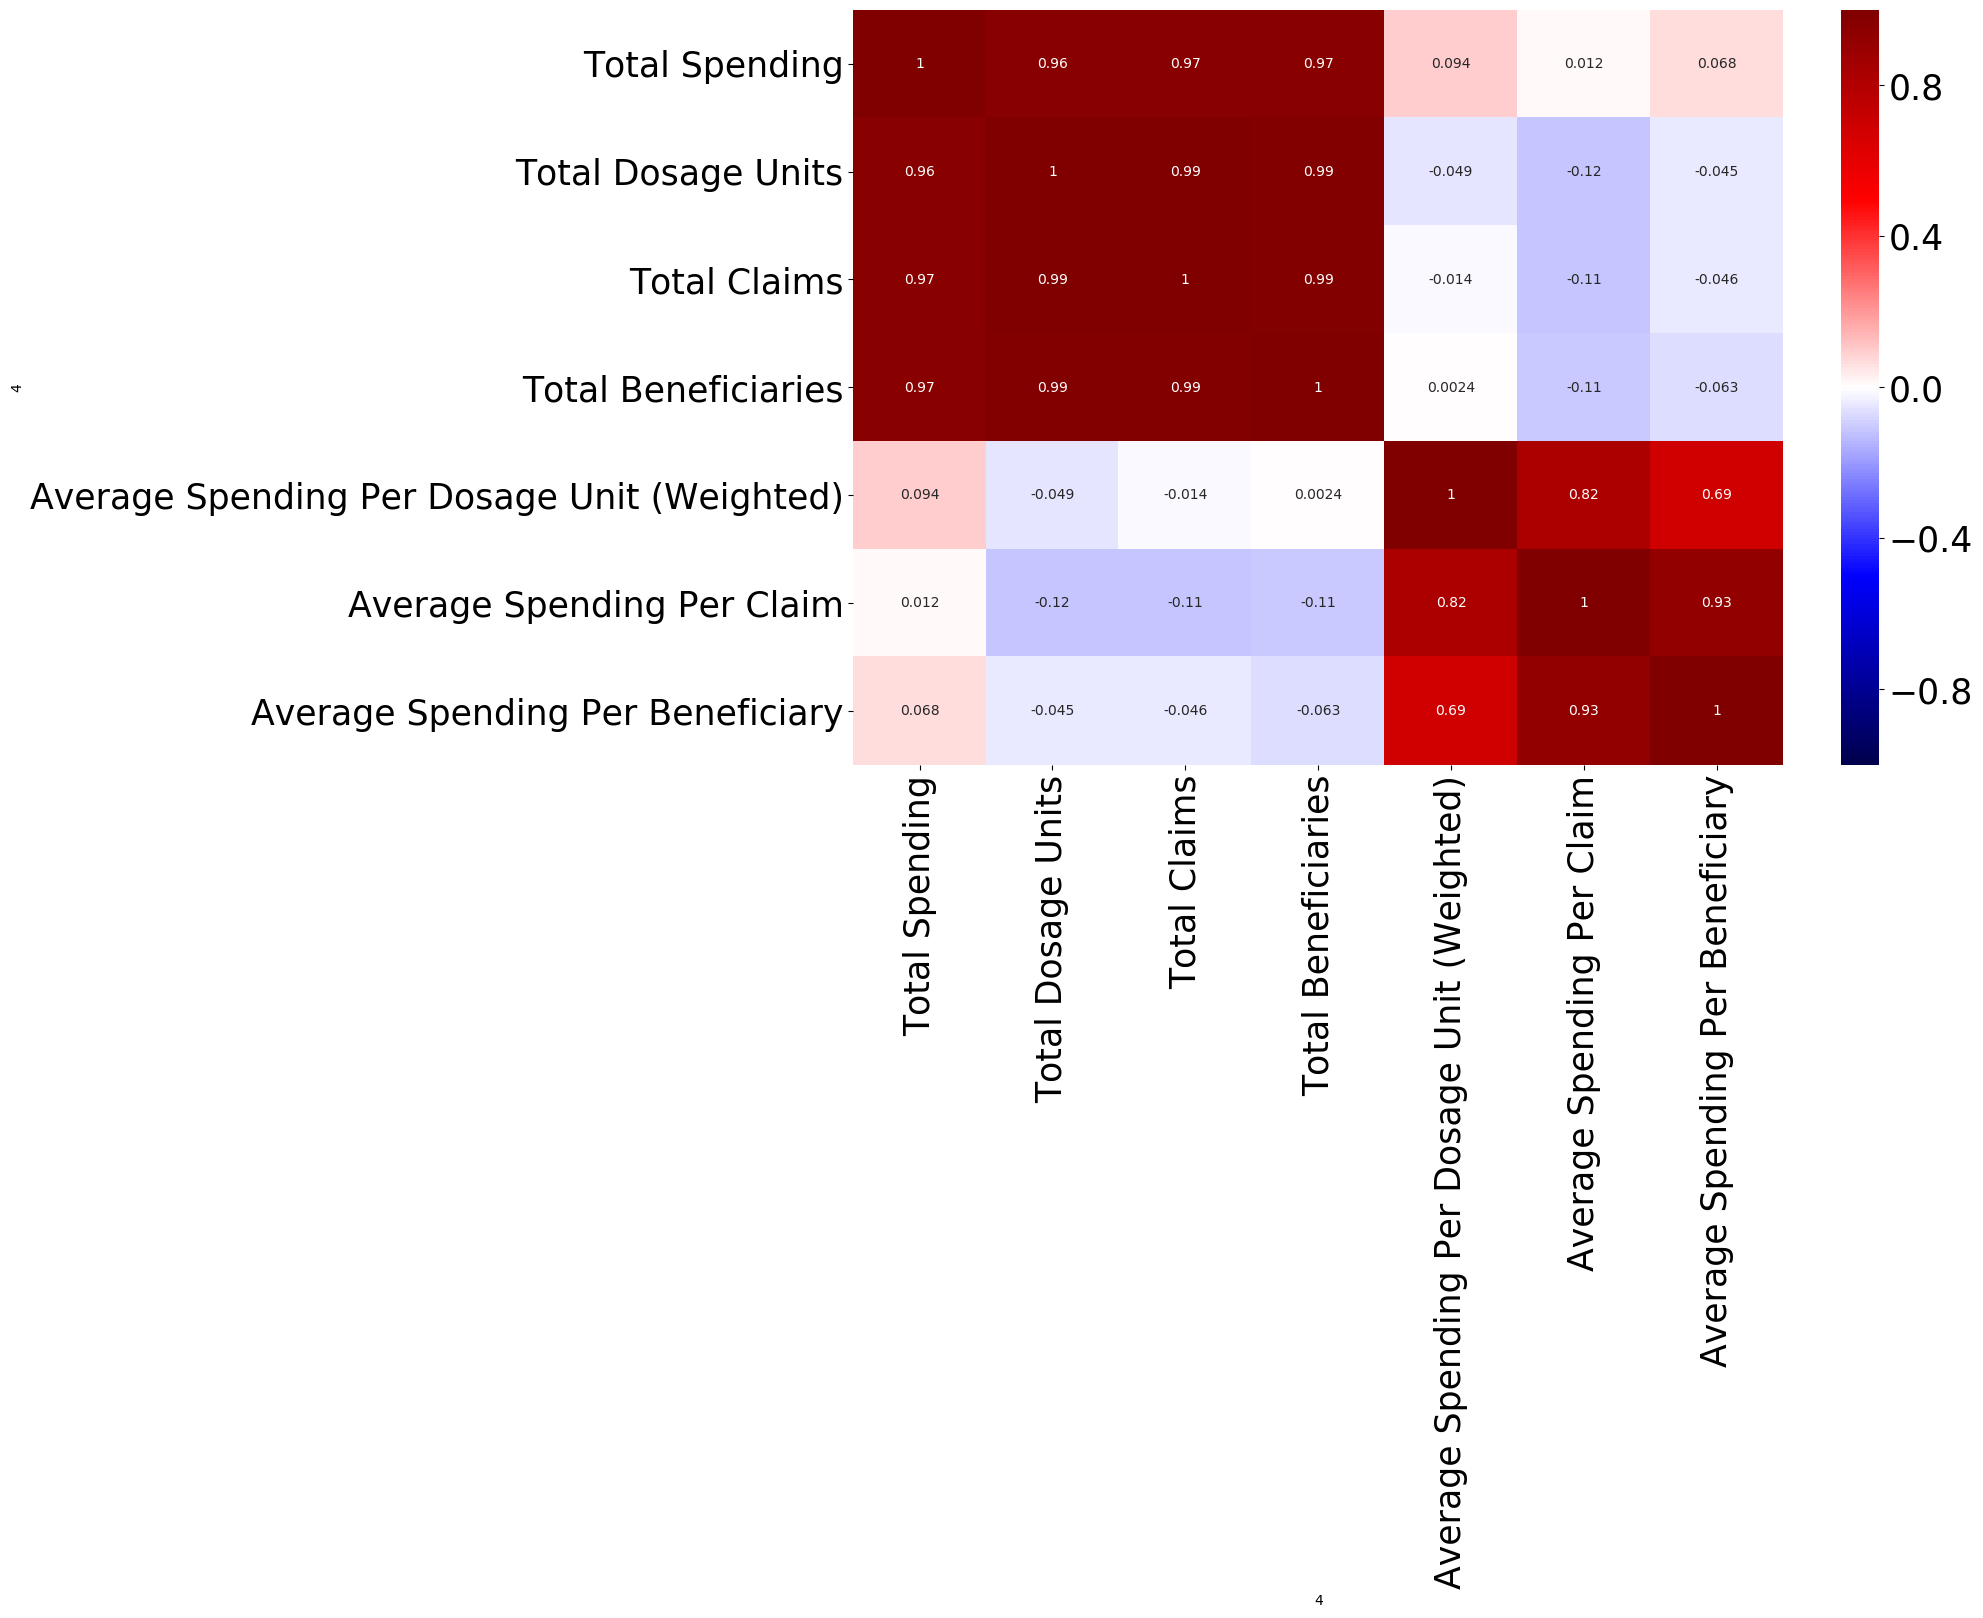

In [201]:
#Holy Auto-correlation Batman!
plt.figure(figsize=(15,10))
sns.heatmap(insulin_df.corr(), cmap='seismic', annot=True,vmin=-1,vmax=1)
plt.savefig('heatmap.png', format = 'png', bbox_inches='tight')

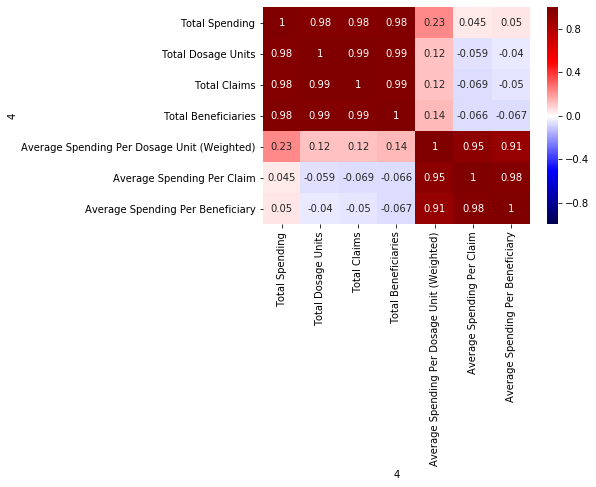

In [26]:
sns.heatmap(insulin_2013.corr(), cmap='seismic', annot=True,vmin=-1,vmax=1)

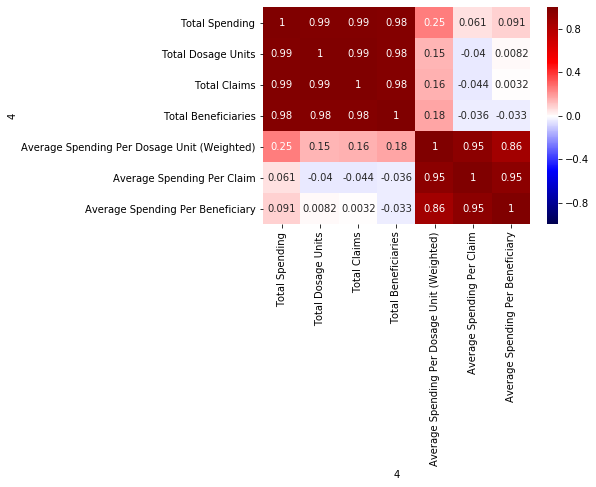

In [27]:
sns.heatmap(insulin_2014.corr(), cmap='seismic', annot=True,vmin=-1,vmax=1)

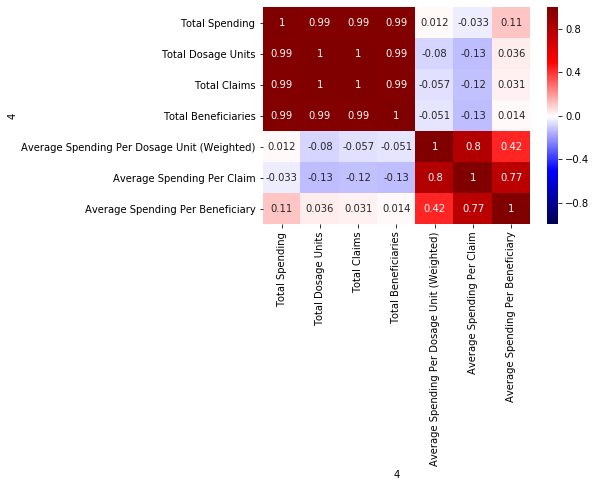

In [28]:
sns.heatmap(insulin_2015.corr(), cmap='seismic', annot=True,vmin=-1,vmax=1)

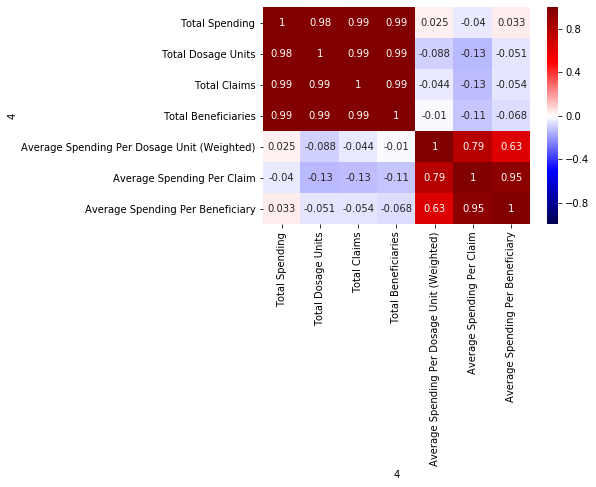

In [29]:
sns.heatmap(insulin_2016.corr(), cmap='seismic', annot=True,vmin=-1,vmax=1)

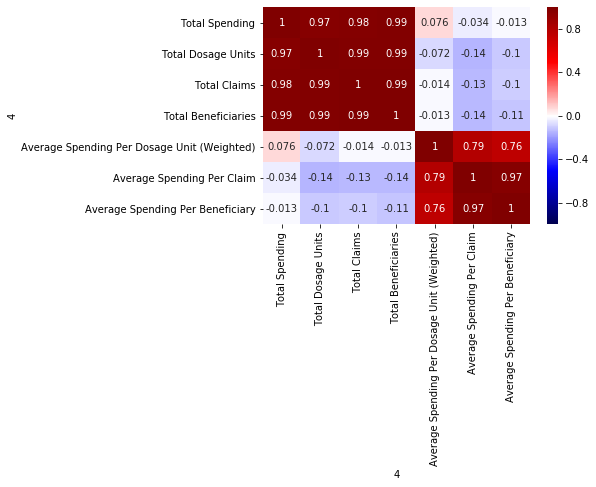

In [30]:
sns.heatmap(insulin_2017.corr(), cmap='seismic', annot=True,vmin=-1,vmax=1)

### Modeling

In [32]:
intcols = ['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries', 'Average Spending Per Dosage Unit (Weighted)', 'Average Spending Per Claim', 'Average Spending Per Beneficiary']
selected_columns = ['Total Dosage Units', 'Total Claims', 'Total Beneficiaries']
smaller_df = insulin_df.loc[:,intcols]

In [33]:
smaller_df = smaller_df.dropna()

In [35]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 29016 to 35494
Data columns (total 7 columns):
Total Spending                                 152 non-null float64
Total Dosage Units                             152 non-null float64
Total Claims                                   152 non-null float64
Total Beneficiaries                            152 non-null float64
Average Spending Per Dosage Unit (Weighted)    152 non-null float64
Average Spending Per Claim                     152 non-null float64
Average Spending Per Beneficiary               152 non-null float64
dtypes: float64(7)
memory usage: 9.5 KB


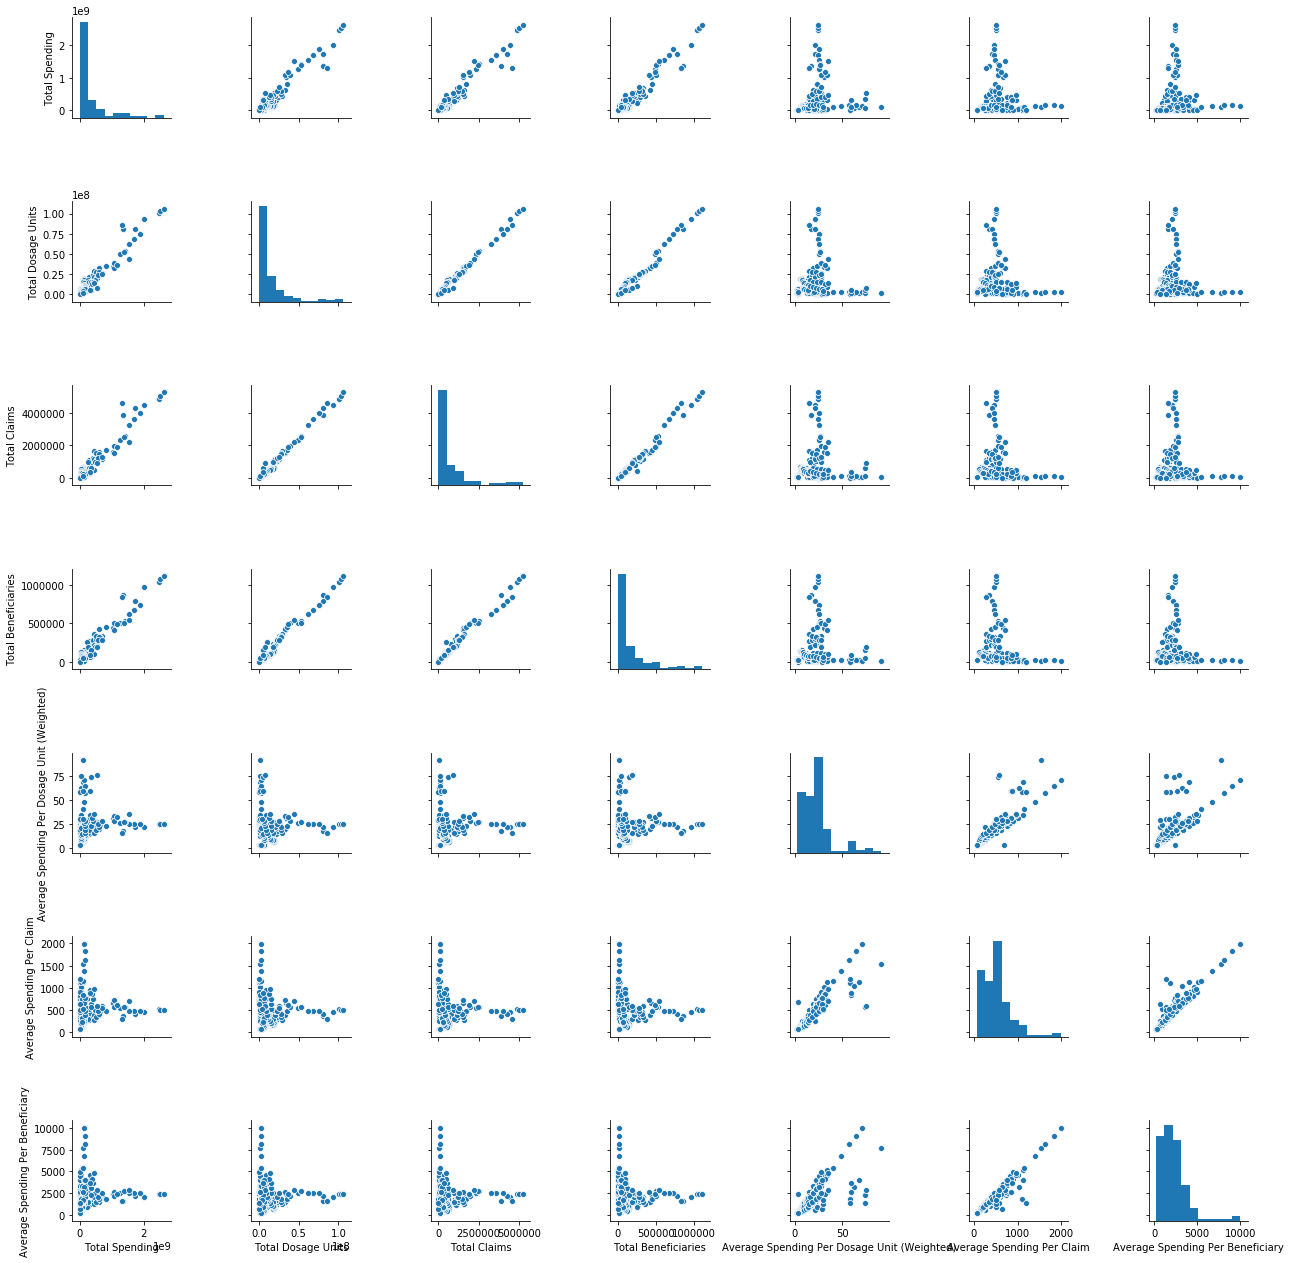

In [36]:
sns.pairplot(smaller_df);

### K-folds

In [38]:
X = smaller_df.loc[:,['Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]
y = smaller_df['Total Spending']

X = X.dropna()
y = y.dropna()

In [40]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [52]:

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_lasso_r2s, cv_lm_elastic_r2s = [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_lasso = Lasso(alpha=1, tol =.03)
    lm_elastic = ElasticNet(alpha=1,l1_ratio=0.5)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    #lasso with feature scaling
    lm_lasso.fit(X_train_scaled, y_train)
    cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))
    
    #elasticnet
    lm_elastic.fit(X_train_scaled, y_train)
    cv_lm_elastic_r2s.append(lm_elastic.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('Lasso scores: ', cv_lm_lasso_r2s, '\n')
print('Elastic Net scores: ', cv_lm_elastic_r2s, '\n')

simple_mean_r2 = np.mean(cv_lm_r2s)
ridge_mean_r2 = np.mean(cv_lm_reg_r2s)
lasso_mean_r2 = np.mean(cv_lm_lasso_r2s)
en_mean_r2 = np.mean(cv_lm_elastic_r2s)

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')
print(f'Elastic Net mean cv r^2: {np.mean(cv_lm_elastic_r2s):.3f} +- {np.std(cv_lm_elastic_r2s):.3f}')


Simple regression scores:  [0.9147312670870833, 0.9267460279156143, 0.7881061628644176, 0.8821569781055655, 0.867641155205753]
Ridge scores:  [0.9176902390700233, 0.9345313918265175, 0.7939487886122573, 0.9110415341618924, 0.8707879010474809] 

Lasso scores:  [0.9147313290250914, 0.9267460272958967, 0.7881061166788463, 0.8821570630718238, 0.8676411212335686] 

Elastic Net scores:  [0.8840220599561023, 0.9351199740360867, 0.7722793545518414, 0.8962761354097372, 0.8686082223149932] 

Simple mean cv r^2: 0.876 +- 0.049
Ridge mean cv r^2: 0.886 +- 0.050
Lasso mean cv r^2: 0.876 +- 0.049
Elastic Net mean cv r^2: 0.871 +- 0.054


In [56]:
#Adjusted R**2

def adj_r2(r_squared):
    return 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train_scaled.shape[1]-1)

adj_r2(simple_mean_r2)

0.8718723285013541

In [57]:
test_list = [simple_mean_r2, ridge_mean_r2, lasso_mean_r2, en_mean_r2]
results_list = []
for test in test_list:
    results_list.append(adj_r2(test))
results_list
#This shows ridge being my best model with an alpha of 1.

[0.8718723285013541, 0.881909647425687, 0.8718723421533372, 0.8671082831006474]

In [61]:
#now to look at optimal alpha values!
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha, tol = 0.03 ))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = rmse(y_val, val_set_pred)

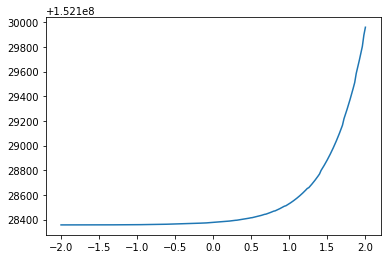

In [62]:
plt.plot(np.log10(alphalist), err_vec_val)

In [63]:
np.min(err_vec_val)

152128357.32530883

In [66]:
best_alpha_lasso = alphalist[np.argmin(err_vec_val)]
best_alpha_lasso

0.019116440753857017

In [67]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha ))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = rmse(y_val, val_set_pred)

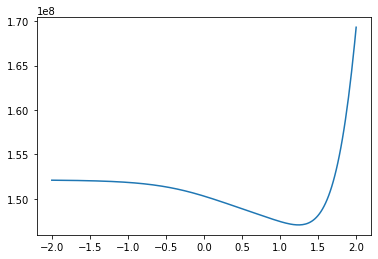

In [69]:
plt.plot(np.log10(alphalist), err_vec_val)

In [70]:
np.min(err_vec_val)

147065574.0044073

In [71]:
best_alpha_ridge = alphalist[np.argmin(err_vec_val)]
best_alpha_ridge

17.225859653987875

In [81]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()), 
             ('elasticnet', ElasticNet(alpha = curr_alpha,l1_ratio=.5))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = rmse(y_val, val_set_pred)

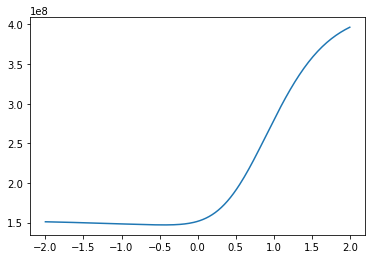

In [82]:
plt.plot(np.log10(alphalist), err_vec_val)

In [74]:
np.min(err_vec_val)

147065985.2835821

In [76]:
best_alpha_en = alphalist[np.argmin(err_vec_val)]
best_alpha_en

0.352970730273065

In [77]:
#Now let's run it again with optimal alphas!

In [78]:

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_lasso_r2s, cv_lm_elastic_r2s = [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=best_alpha_ridge)
    lm_lasso = Lasso(alpha=best_alpha_lasso, tol =.03)
    lm_elastic = ElasticNet(alpha=best_alpha_en,l1_ratio=0.5)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    #lasso with feature scaling
    lm_lasso.fit(X_train_scaled, y_train)
    cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))
    
    #elasticnet
    lm_elastic.fit(X_train_scaled, y_train)
    cv_lm_elastic_r2s.append(lm_elastic.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('Lasso scores: ', cv_lm_lasso_r2s, '\n')
print('Elastic Net scores: ', cv_lm_elastic_r2s, '\n')

simple_mean_r2 = np.mean(cv_lm_r2s)
ridge_mean_r2 = np.mean(cv_lm_reg_r2s)
lasso_mean_r2 = np.mean(cv_lm_lasso_r2s)
en_mean_r2 = np.mean(cv_lm_elastic_r2s)

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')
print(f'Elastic Net mean cv r^2: {np.mean(cv_lm_elastic_r2s):.3f} +- {np.std(cv_lm_elastic_r2s):.3f}')


Simple regression scores:  [0.9147312670870833, 0.9267460279156143, 0.7881061628644176, 0.8821569781055655, 0.867641155205753]
Ridge scores:  [0.9084412091389475, 0.9421970300261121, 0.7930427110678959, 0.9227840918491383, 0.8763042836878926] 

Lasso scores:  [0.9147312988997849, 0.9267460282962591, 0.7881061624290191, 0.8821569820183834, 0.8676411555899266] 

Elastic Net scores:  [0.9086286154082553, 0.9421897125971539, 0.7930892096632478, 0.9228517931793185, 0.8763035918394623] 

Simple mean cv r^2: 0.876 +- 0.049
Ridge mean cv r^2: 0.889 +- 0.052
Lasso mean cv r^2: 0.876 +- 0.049
Elastic Net mean cv r^2: 0.889 +- 0.052


/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.19054224215496e+17, tolerance: 5.666505967170246e+17
  positive)
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.574800339673829e+17, tolerance: 6.165894501150661e+17
  positive)


In [79]:
test_list = [simple_mean_r2, ridge_mean_r2, lasso_mean_r2, en_mean_r2]
results_list = []
for test in test_list:
    results_list.append(adj_r2(test))
results_list

## Looks like an Elastic Net is the winner, now let's optimize elastic net!

[0.8718723285013541, 0.8849588285460619, 0.8718723359449544, 0.885019442103213]

In [87]:
#This did not work. Leaving it at .5.

# netlist = np.linspace(0,1,20)
# # best_r2 = []
# for curr_l1_ratio in netlist:
#     steps = [('standardize', StandardScaler()), 
#              ('ElasticNet', ElasticNet(alpha = best_alpha, l1_ratio=curr_l1_ratio, tol=.05))]

#     pipe = Pipeline(steps)
#     pipe.fit(X_train, y_train)
    
#     print(lm_elastic.score(X_val_scaled, y_val))


-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328
-234.46746600968328


### Applying model to test data

In [150]:
lm_elastic_test = ElasticNet(alpha = best_alpha_en, l1_ratio=.5)
X_test_scaled = scaler.fit_transform(X_test)
lm_elastic_test.fit(X_test_scaled, y_test)

ElasticNet(alpha=0.352970730273065, copy_X=True, fit_intercept=True,
           l1_ratio=0.5, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [151]:
list(zip(selected_columns, lm_elastic_test.coef_))

[('Total Dosage Units', 224096327.4631308),
 ('Total Claims', 232491878.87841812),
 ('Total Beneficiaries', 241582289.64891875)]

In [152]:
lm_elastic_test.score(X_test_scaled,y_test)

#WOAH Unexpectedly higher. Probably due to my dataset being on the smaller side.

0.9778633686925828

In [155]:
lasso_model = Lasso(alpha = best_alpha_en) #had to adjust the tol, since the objective wouldn't converge.
lasso_model.fit(X_train_scaled, y_train)

list(zip(selected_columns, lasso_model.coef_))

[('Total Dosage Units', 69834964.86508916),
 ('Total Claims', 49479539.061537676),
 ('Total Beneficiaries', 321222176.43105733)]

In [44]:
# This k-folds shows ridge/elasticnet to be mildly more effective.
# Additionally, since my heatmaps show my features to be heavily
# colinear, the added bias from one of these models is beneficial.
#Per Jonathan and research, both regressions help with multicolinearity, so that's why I ran an ElasticNet

In [156]:
#Running model on whole dataset for practice.
lm_elastic_whole_model = ElasticNet(alpha = best_alpha_en, l1_ratio=.5)
X_scaled = scaler.fit_transform(X)
lm_elastic_whole_model.fit(X_scaled, y)

ElasticNet(alpha=0.352970730273065, copy_X=True, fit_intercept=True,
           l1_ratio=0.5, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [157]:
list(zip(selected_columns, lm_elastic_whole_model.coef_))

[('Total Dosage Units', 127871076.73020683),
 ('Total Claims', 130119403.26295061),
 ('Total Beneficiaries', 148874472.3499654)]

### Apply model to whole data

In [158]:
lm_elastic_whole_model.score(X_scaled,y)
#this makes sense, since my test data was so high relative to my train.

0.919067502580292

In [159]:
lm_elastic_whole_model.coef_

array([1.27871077e+08, 1.30119403e+08, 1.48874472e+08])

In [162]:
# lm_lasso_whole_model.score(X_scaled,y)
#Running LASSO model on whole dataset for graph consistency
lm_lasso_whole_model = Lasso(alpha = best_alpha_lasso, tol =.035)
X_scaled = scaler.fit_transform(X)
lm_lasso_whole_model.fit(X_scaled, y)

Lasso(alpha=0.019116440753857017, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.035, warm_start=False)

In [163]:
lm_lasso_whole_model.coef_

array([7.96392072e+07, 6.30769737e+07, 2.88653233e+08])

### Loop through dataframes and output their ridge coefficients

In [117]:

df_list = [insulin_2013, insulin_2014, insulin_2015, insulin_2016, insulin_2017]
insulin_2013 = insulin_2013[['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]
insulin_2014 = insulin_2014[['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]
insulin_2015 = insulin_2015[['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]
insulin_2016 = insulin_2016[['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]
insulin_2017 = insulin_2017[['Total Spending', 'Total Dosage Units', 'Total Claims', 'Total Beneficiaries']]

In [136]:
insulin_2013.dropna(inplace=True)
insulin_2014.dropna(inplace=True)
insulin_2015.dropna(inplace=True)
insulin_2016.dropna(inplace=True)
insulin_2017.dropna(inplace=True)

In [137]:
insulin_2013 = insulin_2013.astype(int)
insulin_2014 = insulin_2014.astype(int)
insulin_2015 = insulin_2015.astype(int)
insulin_2016 = insulin_2016.astype(int)
insulin_2017 = insulin_2017.astype(int)

In [148]:

#iterate_elastic_net(smaller_df,42)

#This did not work. A previous model operating on the Lasso Coef is being used for my presentation.
#My computer crashed, and the graph saved to github, so I've uploaded it and will be discussing it instead.
#I would be happy to go over any of this in person to better explain what happened.


[('Total Dosage Units', 88886929.41120191),
 ('Total Claims', 157437238.8019656),
 ('Total Beneficiaries', 285572071.79241014)]

### Graphs

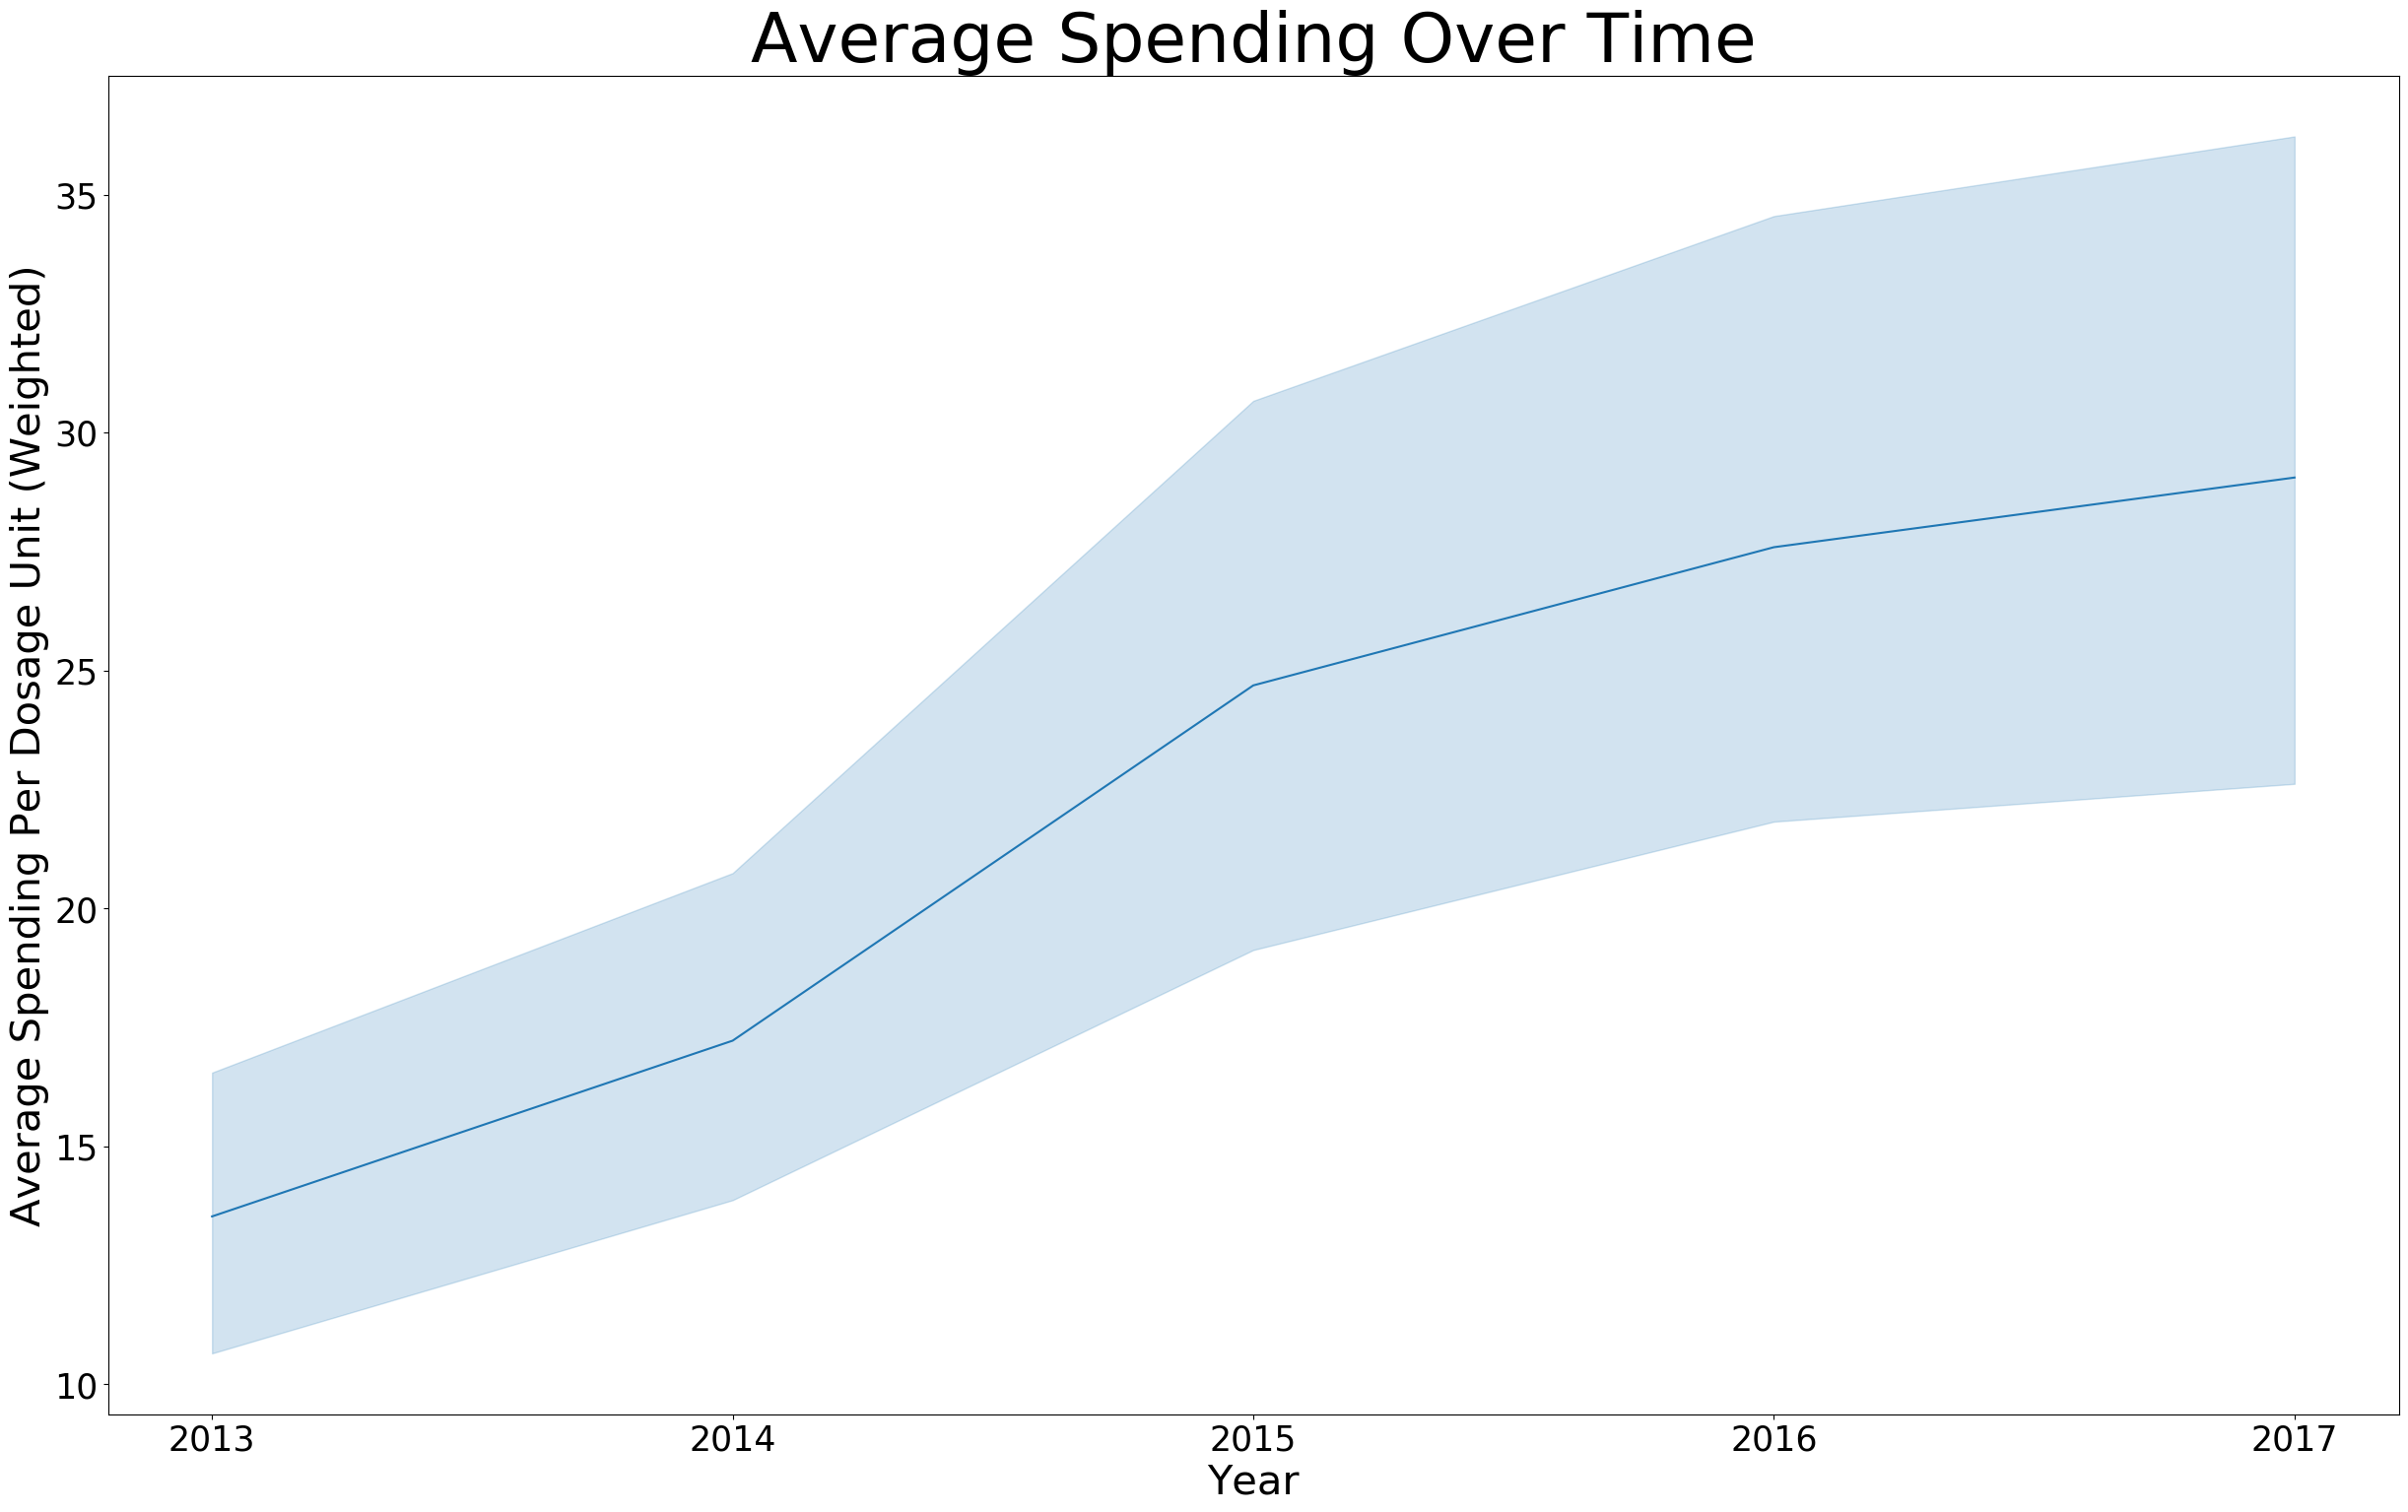

In [173]:

plt.figure(figsize=(30,18))

plt.rcParams["figure.dpi"] = 100
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

spendingplot = sns.lineplot(x='Year', y='Average Spending Per Dosage Unit (Weighted)', data = insulin_df)
spendingplot.set_xlabel('Year',fontsize = 30, color = 'black')
spendingplot.set_ylabel('Average Spending Per Dosage Unit (Weighted)', fontsize = 30, color = 'black')
spendingplot.set_title('Average Spending Over Time', fontsize = 50, color = 'black')
plt.savefig('spendinggrowth.png', format ='png',bbox_inches='tight')


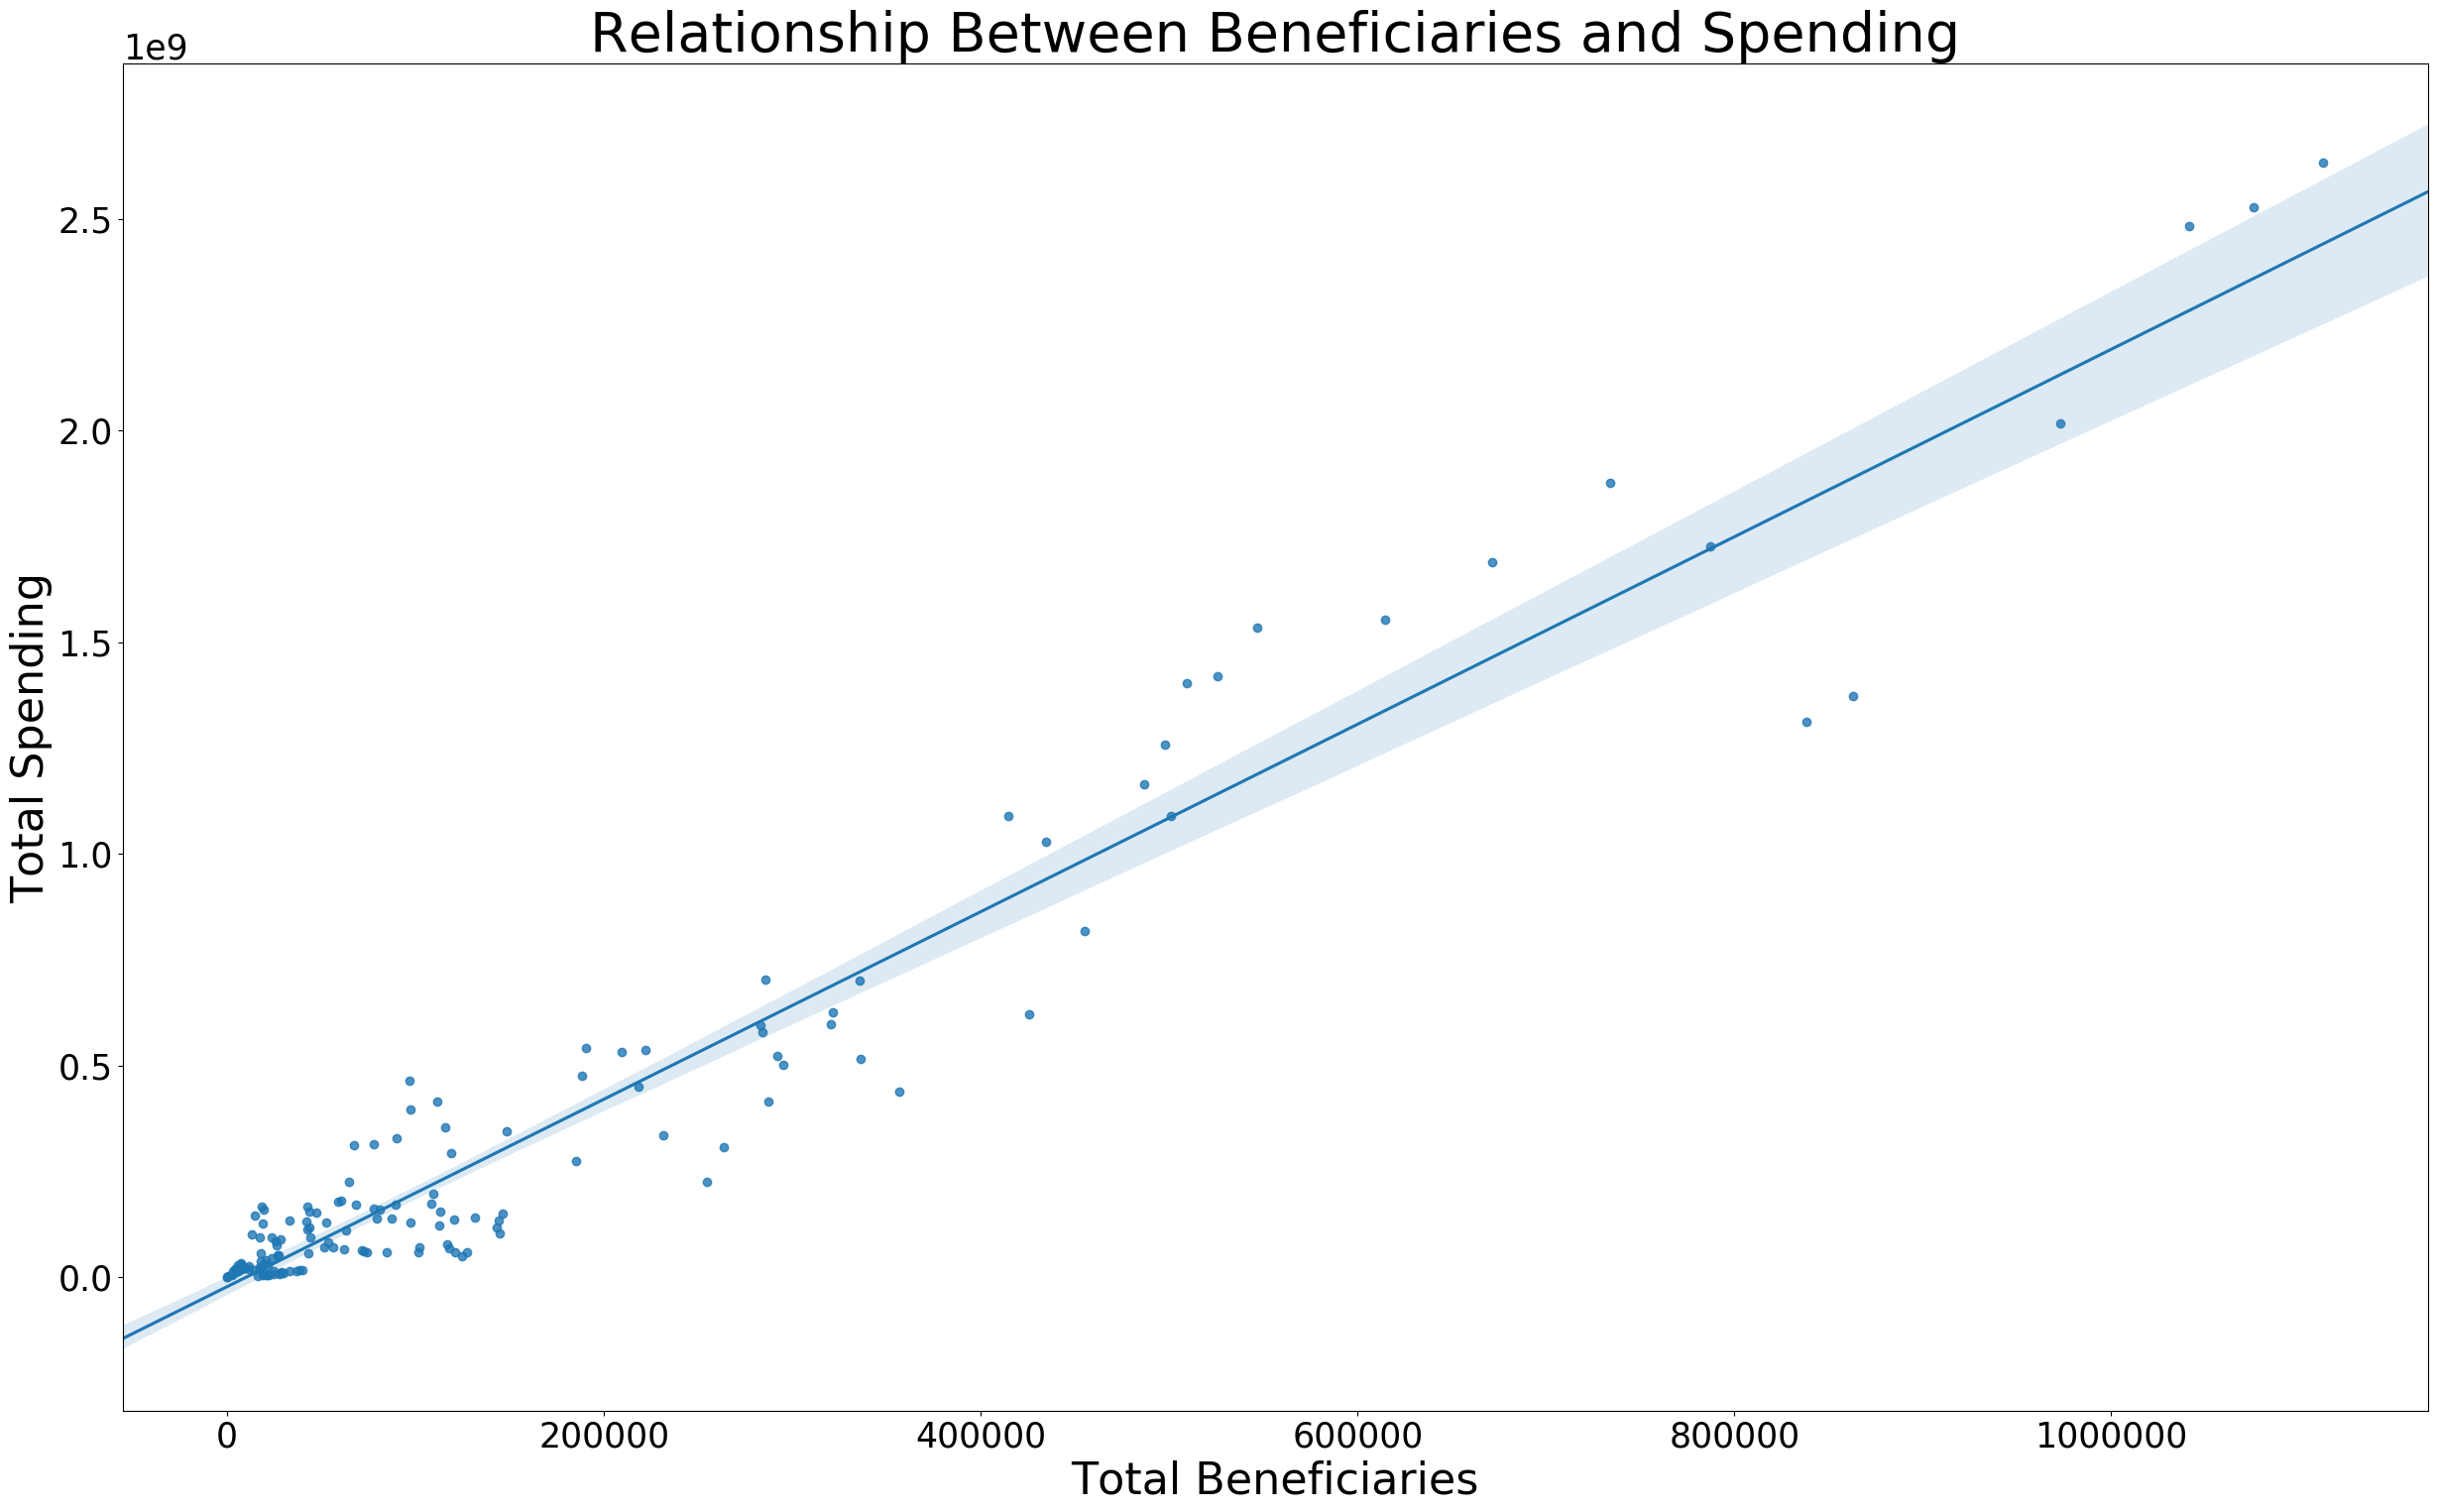

In [191]:

plt.figure(figsize=(30,18))

plt.rcParams["figure.dpi"] = 100
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

regplot = sns.regplot(x='Total Beneficiaries', y = 'Total Spending', data = insulin_df)
regplot.set_xlabel('Total Beneficiaries',fontsize = 32, color = 'black')
regplot.set_ylabel('Total Spending', fontsize = 32, color = 'black')
regplot.set_title('Relationship Between Beneficiaries and Spending', fontsize = 40, color = 'black')
plt.ticklabel_format(style='sci', axis='y')
plt.ticklabel_format(style='sci', axis='x')
# plt.savefig('regplot.png', format ='png',bbox_inches='tight')


/home/nick/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Search Rate')

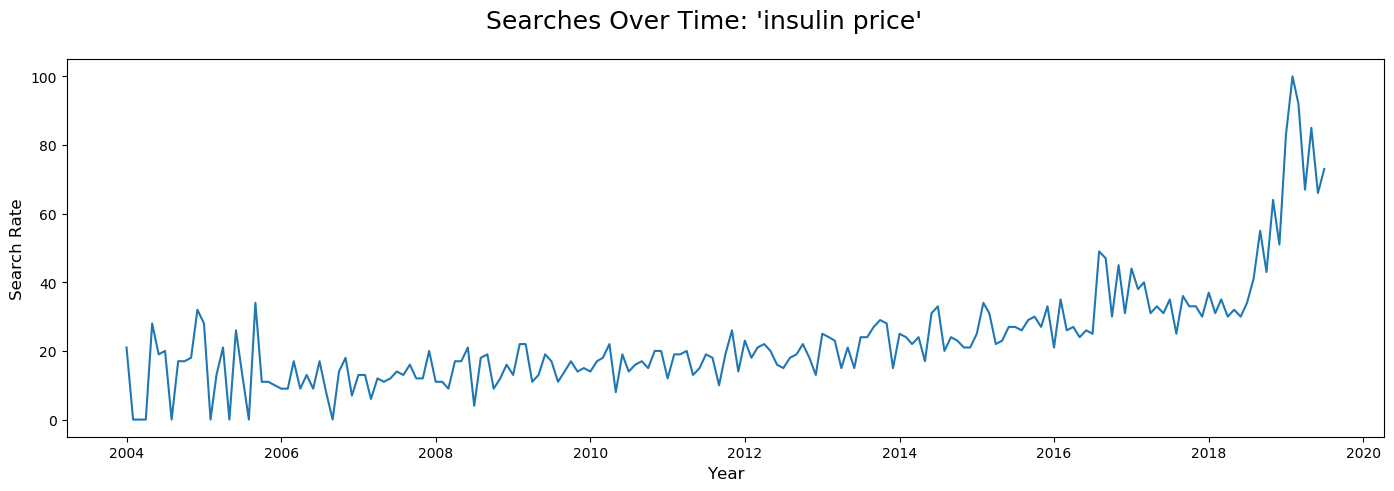

In [202]:
google_data = pd.read_csv('multiTimeline.csv', skiprows=2, parse_dates=['Month'], index_col=['Month'])
# plt.plot(data))
google_data
plt.figure(figsize=(17,5))
plt.rcParams.update(plt.rcParamsDefault)


# color = 'white'
# plt.rcParams['text.color'] = color
# plt.rcParams['axes.labelcolor'] = color
# plt.rcParams['xtick.color'] = color
# plt.rcParams['ytick.color'] = color
# plt.rcParams["figure.dpi"] = 100
# sns.despine()

trendsplot = plt.plot(google_data)
plt.suptitle("Searches Over Time: 'insulin price'", fontsize=18)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Search Rate', fontsize=12)
# plt.savefig('trendsdata.png', format ='png',bbox_inches='tight')

ConversionError: Failed to convert value(s) to axis units: array(['2013', '2014', '2015', '2016', '2017', '2013', '2014', '2015',
       '2016', '2017', '2013', '2014', '2015', '2016', '2017', '2013',
       '2014', '2015', '2016', '2017', '2013', '2014', '2015', '2016',
       '2017', '2013', '2014', '2015', '2016', '2017', '2013', '2014',
       '2015', '2016', '2017', '2013', '2014', '2015', '2016', '2017',
       '2013', '2014', '2015', '2016', '2017', '2013', '2014', '2015',
       '2016', '2017', '2013', '2014', '2015', '2016', '2017', '2013',
       '2014', '2015', '2016', '2017', '2013', '2014', '2015', '2016',
       '2017', '2013', '2014', '2015', '2016', '2017', '2013', '2014',
       '2015', '2016', '2017', '2013', '2014', '2015', '2016', '2017',
       '2013', '2014', '2015', '2016', '2017', '2013', '2014', '2015',
       '2016', '2017', '2013', '2014', '2015', '2016', '2017', '2013',
       '2014', '2015', '2016', '2017', '2013', '2014', '2015', '2016',
       '2017', '2013', '2014', '2015', '2016', '2017', '2013', '2014',
       '2015', '2016', '2017', '2013', '2014', '2015', '2016', '2017',
       '2013', '2014', '2015', '2016', '2017', '2013', '2014', '2015',
       '2016', '2017', '2013', '2014', '2015', '2016', '2017', '2013',
       '2014', '2015', '2016', '2017', '2013', '2014', '2015', '2016',
       '2017', '2013', '2014', '2015', '2016', '2017', '2013', '2014',
       '2015', '2016', '2017', '2013', '2014', '2015', '2016', '2017',
       '2013', '2014', '2015', '2016', '2017', '2013', '2014', '2015',
       '2016', '2017', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

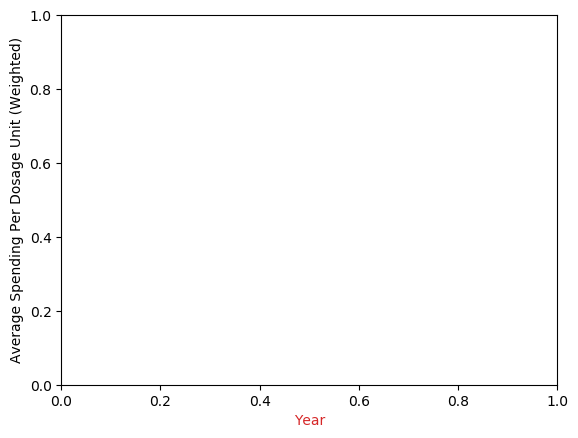

<Figure size 1000x1000 with 0 Axes>

In [213]:
# this was me trying to figure out how to doubleplot the googletrends cost data. I did not succeed.

# spending_time_df = insulin_df[['Average Spending Per Dosage Unit (Weighted)','Year']]

# fig, ax1 = plt.subplots()


# plt.figure(figsize=(10,10))

# color = 'tab:red'
# ax1.set_xlabel('Year', color=color)
# ax1.set_ylabel('Average Spending Per Dosage Unit (Weighted)')
# ax1.plot(spending_time_df,)
# ax1.tick_params(axis = 'y')
           
# ax2 = ax1.twinx()
           
# color  = 'tab:blue'
# ax2.set_ylabel('Search Rates')
# ax2.plot(google_data)
# ax2.tick_params(axis= 'y')
# fig.tight_layout()
# # plt.figure(figsize=(30,18))

# # plt.rcParams["figure.dpi"] = 100
# # plt.rc('xtick', labelsize=25)
# # plt.rc('ytick', labelsize=25)

# # spendingplot = sns.lineplot(x='Year', y='Average Spending Per Dosage Unit (Weighted)', data = insulin_df)
# # spendingplot.set_xlabel('Year',fontsize = 30, color = 'black')
# # spendingplot.set_ylabel('Average Spending Per Dosage Unit (Weighted)', fontsize = 30, color = 'black')
# # spendingplot.set_title('Average Spending Over Time', fontsize = 50, color = 'black')
# # plt.savefig('spendinggrowth.png', format ='png',bbox_inches='tight')

In [205]:
insulin_df.head()

4,ID,Year,Total Spending,Total Dosage Units,Total Claims,Total Beneficiaries,Average Spending Per Dosage Unit (Weighted),Average Spending Per Claim,Average Spending Per Beneficiary,dt_year
136,"Afrezza/Insulin Regular, Human/Mannkind Corpor",2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01
7356,"Afrezza/Insulin Regular, Human/Mannkind Corpor",2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01
14576,"Afrezza/Insulin Regular, Human/Mannkind Corpor",2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
21796,"Afrezza/Insulin Regular, Human/Mannkind Corpor",2016,396166.93,134460.0,700.0,NaN,2.914455,565.952757,NaN,2016-01-01
29016,"Afrezza/Insulin Regular, Human/Mannkind Corpor",2017,1538984.50,424278.0,2231.0,639.0,3.543422,689.818243,2408.426448,2017-01-01
